In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
import os

In [6]:
# set random seed
np.random.seed(123)
tf.set_random_seed(123)

# import the training data 
X_total = pd.read_csv('X_musical_features.csv').drop('track_id', axis=1)

# import single genres y values
y_single_total = pd.read_csv('y_genres_onehot_single.csv').drop('Unnamed: 0', axis=1)

# import non-one-hotted y values
y_cold_single_total = pd.read_csv('y_genres_single.csv')

#import multiple genres y values
y_cold_multiple_total = pd.read_csv('y_genres_multiple_cold.csv')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_single_total, test_size=0.3, shuffle=False, stratify = None
)

# also split y cold 70/30
y_cold_train = y_cold_single_total.head(44559)
y_cold_test = y_cold_single_total.tail(y_cold_single_total.shape[0] - 44559)

#also split y cold multiple 70/30
y_cold_train_multiple = y_cold_multiple_total.head(44559)
y_cold_test_multiple = y_cold_multiple_total.tail(y_cold_single_total.shape[0] - 44559)

# then do this for 
# *_train together
# *_test together
def unison_shuffled_copies(a, b, c, d):
    assert len(a) == b.shape[0]
    assert a.shape[0] == c.shape[0]
    assert a.shape[0] == d.shape[0]
    
    p = np.random.permutation(len(a))
    return a.iloc[p, :], b.iloc[p, :], c.iloc[p, :], d.iloc[p, :]

#new variables with shuffled 
X_train_shuf, y_train_shuf, y_cold_train_shuf, y_cold_train_multiple_shuf = unison_shuffled_copies(X_train, y_train, y_cold_train, y_cold_train_multiple)

#also do this for test set

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_shuf)
X_test_scaled = scaler.transform(X_test)

In [6]:
# del X_train, X_test

In [12]:
#def create_model(loss):
model = keras.models.Sequential()
sgd_optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-7, momentum=0.9)

# INPUT LAYER
model.add(
    keras.layers.Dense(
        units=518,
        input_dim=X_train_scaled.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
        activation='relu',
    )
)

# HIDDEN LAYER 1
#     model.add(
#         keras.layers.Dense(
#             units=474,
#             input_dim=518,
#             kernel_initializer='glorot_uniform',
#             bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
#             activation='relu'
#         )
#     )

# HIDDEN LAYER 2
model.add(
    keras.layers.Dense(
        units=400,
        input_dim=518,
        kernel_initializer='glorot_uniform',
        bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
        activation='relu',
        #kernel_regularizer=regularizers.l2(0.0002),
        #activity_regularizer=regularizers.l1(0.0002),
    )
)
model.add(keras.layers.Dropout(0.55))

# HIDDEN LAYER 3
model.add(
    keras.layers.Dense(
        units=350,
        input_dim=400,
        kernel_initializer='glorot_uniform',
        bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
        activation='relu',
        #kernel_regularizer=regularizers.l2(0.0002),
        #activity_regularizer=regularizers.l1(0.0002),
    )
)
model.add(keras.layers.Dropout(0.55))

# OUTPUT LAYER
model.add(
    keras.layers.Dense(
        units=y_train.shape[1],
        input_dim=350,
        kernel_initializer='glorot_uniform',
        bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
        activation='softmax'
    )
)

model.compile(
    optimizer=sgd_optimizer,
    loss='kullback_leibler_divergence',
    metrics=['accuracy'],
)
    
    #return model

## Best Things So Far
* Batch Size: **60** _(maybe 64 to optimize because of powers of 2)_
* Optimizer: **SGD**
* Learning Rate: **0.1**
    * **HEAVY NOTE** I tried it with 0.1 and it literally exploded (like val_acc went from 3 to 6.5 in one epoch) so I think we don't converge properly with such a high lr. Going back to 0.01 may be optimal but further testing required. 
    * Final acc with 0.01: around 0.95
    * Final acc with 0.1: like 0.3
* Momentum: **0.9**
* Neurons in Hidden Layer 1: **400**
* Neurons in Hidden Layer 2: **350**
* Loss equation: **Kullback_leibler_divergence?**


In [6]:
# model = KerasClassifier(
#     build_fn=create_model,
#     batch_size=64,
#     epochs=20,
#     verbose=1)

# losses = [  'binary_crossentropy' ,
#             'kullback_leibler_divergence' , 'poisson' , 'cosine_proximity']
# param_grid = dict(loss=losses)

# grid = GridSearchCV(
#     estimator=model, 
#     param_grid=param_grid, 
#     n_jobs=1,
#     verbose=9,
# )

# #TRY RUNNING THIS WITH X_TRAIN_SCALED AND Y_TRAIN_SHUF, WE MAY BE USING THE UNSHUFFLED TEST DATA FOR THIS
# #WHICH IS ONLY 30% OF THE TOTAL DATA AND IT IS UNSHUFFLED
# grid_result = grid.fit(X_train_scaled, y_train_shuf)

C:\Users\TonyX\Desktop\WPy-3670\python-3.6.7.amd64\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] loss=binary_crossentropy ........................................
Epoch 1/20
29706/29706 [==============================] - 5s 162us/step - loss: 0.0412 - acc: 0.9928
Epoch 2/20
29706/29706 [==============================] - 4s 150us/step - loss: 0.0364 - acc: 0.9928
Epoch 3/20
29706/29706 [==============================] - 6s 189us/step - loss: 0.0340 - acc: 0.9927
Epoch 4/20
29706/29706 [==============================] - 5s 168us/step - loss: 0.0329 - acc: 0.9927
Epoch 5/20
29706/29706 [==============================] - 5s 156us/step - loss: 0.0322 - acc: 0.9927
Epoch 6/20
29706/29706 [==============================] - 5s 156us/step - loss: 0.0317 - acc: 0.9927
Epoch 7/20
29706/29706 [==============================] - 5s 154us/step - loss: 0.0312 - acc: 0.9927
Epoch 8/20
29706/29706 [==============================] - 4s 150us/step - loss: 0.0309 - acc: 0.9928
Epoch 9/20
29706/29706 [==============================] - 4s 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


Epoch 1/20
29706/29706 [==============================] - 6s 194us/step - loss: 0.0409 - acc: 0.9928
Epoch 2/20
29706/29706 [==============================] - 5s 172us/step - loss: 0.0364 - acc: 0.9928
Epoch 3/20
29706/29706 [==============================] - 5s 165us/step - loss: 0.0341 - acc: 0.9927
Epoch 4/20
29706/29706 [==============================] - 7s 228us/step - loss: 0.0331 - acc: 0.9927
Epoch 5/20
29706/29706 [==============================] - 5s 184us/step - loss: 0.0324 - acc: 0.9927
Epoch 6/20
29706/29706 [==============================] - 5s 178us/step - loss: 0.0319 - acc: 0.9928
Epoch 7/20
29706/29706 [==============================] - 5s 162us/step - loss: 0.0315 - acc: 0.9927
Epoch 8/20
29706/29706 [==============================] - 5s 164us/step - loss: 0.0311 - acc: 0.9928
Epoch 9/20
29706/29706 [==============================] - 5s 160us/step - loss: 0.0309 - acc: 0.9927
Epoch 10/20
29706/29706 [==============================] - 5s 161us/step - loss: 0.0306 - a

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min remaining:    0.0s


Epoch 1/20
29706/29706 [==============================] - 5s 169us/step - loss: 0.0407 - acc: 0.9928
Epoch 2/20
29706/29706 [==============================] - 4s 143us/step - loss: 0.0362 - acc: 0.9928
Epoch 3/20
29706/29706 [==============================] - 5s 176us/step - loss: 0.0341 - acc: 0.9928
Epoch 4/20
29706/29706 [==============================] - 4s 144us/step - loss: 0.0331 - acc: 0.9928
Epoch 5/20
29706/29706 [==============================] - 5s 172us/step - loss: 0.0324 - acc: 0.9928
Epoch 6/20
29706/29706 [==============================] - 5s 178us/step - loss: 0.0319 - acc: 0.9928
Epoch 7/20
29706/29706 [==============================] - 5s 154us/step - loss: 0.0315 - acc: 0.9928
Epoch 8/20
29706/29706 [==============================] - 5s 157us/step - loss: 0.0312 - acc: 0.9928
Epoch 9/20
29706/29706 [==============================] - 5s 157us/step - loss: 0.0308 - acc: 0.9928
Epoch 10/20
29706/29706 [==============================] - 5s 158us/step - loss: 0.0306 - a

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.0min remaining:    0.0s


Epoch 1/20
29706/29706 [==============================] - 5s 176us/step - loss: 3.0024 - acc: 0.2450
Epoch 2/20
29706/29706 [==============================] - 5s 163us/step - loss: 2.6049 - acc: 0.3070
Epoch 3/20
29706/29706 [==============================] - 5s 167us/step - loss: 2.4526 - acc: 0.3329
Epoch 4/20
29706/29706 [==============================] - 5s 158us/step - loss: 2.3410 - acc: 0.3553
Epoch 5/20
29706/29706 [==============================] - 5s 156us/step - loss: 2.2358 - acc: 0.3773
Epoch 6/20
29706/29706 [==============================] - 5s 154us/step - loss: 2.1492 - acc: 0.3928
Epoch 7/20
29706/29706 [==============================] - 5s 156us/step - loss: 2.0634 - acc: 0.4135
Epoch 8/20
29706/29706 [==============================] - 5s 160us/step - loss: 1.9792 - acc: 0.4351
Epoch 9/20
29706/29706 [==============================] - 5s 159us/step - loss: 1.8922 - acc: 0.4553
Epoch 10/20
29706/29706 [==============================] - 5s 162us/step - loss: 1.8079 - a

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.6min remaining:    0.0s


Epoch 1/20
29706/29706 [==============================] - 7s 225us/step - loss: 3.0246 - acc: 0.2447
Epoch 2/20
29706/29706 [==============================] - 5s 180us/step - loss: 2.6309 - acc: 0.3075
Epoch 3/20
29706/29706 [==============================] - 6s 193us/step - loss: 2.4776 - acc: 0.3307
Epoch 4/20
29706/29706 [==============================] - 6s 193us/step - loss: 2.3594 - acc: 0.3498
Epoch 5/20
29706/29706 [==============================] - 5s 172us/step - loss: 2.2510 - acc: 0.3760
Epoch 6/20
29706/29706 [==============================] - 5s 182us/step - loss: 2.1603 - acc: 0.3897
Epoch 7/20
29706/29706 [==============================] - 6s 197us/step - loss: 2.0648 - acc: 0.4133 1s - l
Epoch 8/20
29706/29706 [==============================] - 5s 174us/step - loss: 1.9760 - acc: 0.4369
Epoch 9/20
29706/29706 [==============================] - 5s 169us/step - loss: 1.8968 - acc: 0.4562
Epoch 10/20
29706/29706 [==============================] - 5s 160us/step - loss: 1.8

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.5min remaining:    0.0s


Epoch 1/20
29706/29706 [==============================] - 7s 227us/step - loss: 3.0156 - acc: 0.2426
Epoch 2/20
29706/29706 [==============================] - 7s 227us/step - loss: 2.6116 - acc: 0.3101
Epoch 3/20
29706/29706 [==============================] - 6s 190us/step - loss: 2.4703 - acc: 0.3320
Epoch 4/20
29706/29706 [==============================] - 6s 212us/step - loss: 2.3456 - acc: 0.3551
Epoch 5/20
29706/29706 [==============================] - 6s 205us/step - loss: 2.2444 - acc: 0.3752
Epoch 6/20
29706/29706 [==============================] - 6s 207us/step - loss: 2.1533 - acc: 0.3946
Epoch 7/20
29706/29706 [==============================] - 5s 161us/step - loss: 2.0632 - acc: 0.4155
Epoch 8/20
29706/29706 [==============================] - 5s 161us/step - loss: 1.9782 - acc: 0.4329
Epoch 9/20
29706/29706 [==============================] - 5s 170us/step - loss: 1.9013 - acc: 0.4496
Epoch 10/20
29706/29706 [==============================] - 5s 165us/step - loss: 1.8092 - a

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 10.7min remaining:    0.0s


Epoch 1/20
29706/29706 [==============================] - 8s 267us/step - loss: 0.0402 - acc: 0.0957
Epoch 2/20
29706/29706 [==============================] - 6s 215us/step - loss: 0.0358 - acc: 0.1284
Epoch 3/20
29706/29706 [==============================] - 6s 217us/step - loss: 0.0339 - acc: 0.1359
Epoch 4/20
29706/29706 [==============================] - 7s 225us/step - loss: 0.0330 - acc: 0.1405
Epoch 5/20
29706/29706 [==============================] - 7s 229us/step - loss: 0.0324 - acc: 0.1537
Epoch 6/20
29706/29706 [==============================] - 6s 198us/step - loss: 0.0319 - acc: 0.1633
Epoch 7/20
29706/29706 [==============================] - 6s 206us/step - loss: 0.0316 - acc: 0.1720
Epoch 8/20
29706/29706 [==============================] - 7s 220us/step - loss: 0.0312 - acc: 0.1792
Epoch 9/20
29706/29706 [==============================] - 6s 198us/step - loss: 0.0309 - acc: 0.1828
Epoch 10/20
29706/29706 [==============================] - 6s 216us/step - loss: 0.0307 - a

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 12.9min remaining:    0.0s


Epoch 1/20
29706/29706 [==============================] - 5s 184us/step - loss: 0.0413 - acc: 0.0643
Epoch 2/20
29706/29706 [==============================] - 7s 225us/step - loss: 0.0370 - acc: 0.1317
Epoch 3/20
29706/29706 [==============================] - 6s 202us/step - loss: 0.0348 - acc: 0.1416
Epoch 4/20
29706/29706 [==============================] - 6s 218us/step - loss: 0.0336 - acc: 0.1474
Epoch 5/20
29706/29706 [==============================] - 6s 216us/step - loss: 0.0329 - acc: 0.1533
Epoch 6/20
29706/29706 [==============================] - 7s 226us/step - loss: 0.0323 - acc: 0.1642 2s - loss: 0
Epoch 7/20
29706/29706 [==============================] - 6s 214us/step - loss: 0.0319 - acc: 0.1687
Epoch 8/20
29706/29706 [==============================] - 6s 197us/step - loss: 0.0316 - acc: 0.1757
Epoch 9/20
29706/29706 [==============================] - 6s 203us/step - loss: 0.0313 - acc: 0.1810
Epoch 10/20
29706/29706 [==============================] - 6s 215us/step - los

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 15.1min remaining:    0.0s


Epoch 1/20
29706/29706 [==============================] - 5s 183us/step - loss: 0.0401 - acc: 0.0817
Epoch 2/20
29706/29706 [==============================] - 6s 196us/step - loss: 0.0360 - acc: 0.1316
Epoch 3/20
29706/29706 [==============================] - 7s 250us/step - loss: 0.0340 - acc: 0.1424
Epoch 4/20
29706/29706 [==============================] - 5s 163us/step - loss: 0.0331 - acc: 0.1497
Epoch 5/20
29706/29706 [==============================] - 4s 149us/step - loss: 0.0324 - acc: 0.1570
Epoch 6/20
29706/29706 [==============================] - 4s 149us/step - loss: 0.0320 - acc: 0.1664
Epoch 7/20
29706/29706 [==============================] - 5s 170us/step - loss: 0.0316 - acc: 0.1707
Epoch 8/20
29706/29706 [==============================] - 4s 147us/step - loss: 0.0312 - acc: 0.1817
Epoch 9/20
29706/29706 [==============================] - 5s 169us/step - loss: 0.0310 - acc: 0.1879
Epoch 10/20
29706/29706 [==============================] - 5s 155us/step - loss: 0.0308 - a

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 22.0min finished


Epoch 1/20
44559/44559 [==============================] - 9s 193us/step - loss: 0.0399 - acc: 0.9928
Epoch 2/20
44559/44559 [==============================] - 8s 174us/step - loss: 0.0347 - acc: 0.9927
Epoch 3/20
44559/44559 [==============================] - 8s 173us/step - loss: 0.0330 - acc: 0.9927
Epoch 4/20
44559/44559 [==============================] - 8s 172us/step - loss: 0.0320 - acc: 0.9927
Epoch 5/20
44559/44559 [==============================] - 8s 182us/step - loss: 0.0314 - acc: 0.9927
Epoch 6/20
44559/44559 [==============================] - 8s 179us/step - loss: 0.0308 - acc: 0.9927
Epoch 7/20
44559/44559 [==============================] - 8s 185us/step - loss: 0.0305 - acc: 0.9928
Epoch 8/20
44559/44559 [==============================] - 8s 179us/step - loss: 0.0301 - acc: 0.9928
Epoch 9/20
44559/44559 [==============================] - 8s 173us/step - loss: 0.0298 - acc: 0.9928
Epoch 10/20
44559/44559 [==============================] - 8s 178us/step - loss: 0.0295 - a

In [7]:
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.992883 using {'loss': 'binary_crossentropy'}
0.992883 (0.000010) with: {'loss': 'binary_crossentropy'}
0.382212 (0.002926) with: {'loss': 'kullback_leibler_divergence'}
0.264167 (0.001254) with: {'loss': 'poisson'}
0.356426 (0.004339) with: {'loss': 'cosine_proximity'}


Higher epoch exhibits jumping behavior and failing to converge, consider turning decay higher?

Train on 44559 samples, validate on 19097 samples
Epoch 1/20
44559/44559 [==============================] - 16s 361us/step - loss: 3.6756 - acc: 0.1456 - val_loss: 3.0975 - val_acc: 0.2523
Epoch 2/20
44559/44559 [==============================] - 15s 327us/step - loss: 3.1819 - acc: 0.2129 - val_loss: 2.9309 - val_acc: 0.2737
Epoch 3/20
44559/44559 [==============================] - 14s 323us/step - loss: 3.0162 - acc: 0.2392 - val_loss: 2.8428 - val_acc: 0.2812
Epoch 4/20
44559/44559 [==============================] - 14s 317us/step - loss: 2.9214 - acc: 0.2542 - val_loss: 2.7804 - val_acc: 0.2854
Epoch 5/20
44559/44559 [==============================] - 14s 312us/step - loss: 2.8489 - acc: 0.2714 - val_loss: 2.7369 - val_acc: 0.2963
Epoch 6/20
44559/44559 [==============================] - 16s 352us/step - loss: 2.7947 - acc: 0.2771 - val_loss: 2.7084 - val_acc: 0.2991
Epoch 7/20
44559/44559 [==============================] - 17s 389us/step - loss: 2.7470 - acc: 0.2876 - val_loss: 2.

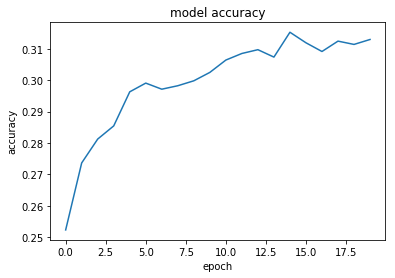

In [13]:
history = model.fit(
X_train_scaled, y_train_shuf,
batch_size=64, epochs=20,
verbose=1,
validation_data=(X_test_scaled, y_test),
)

plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['gn', 'gu', 'ln', 'lu', 'hn', 'hu'], loc='upper left')
plt.show()

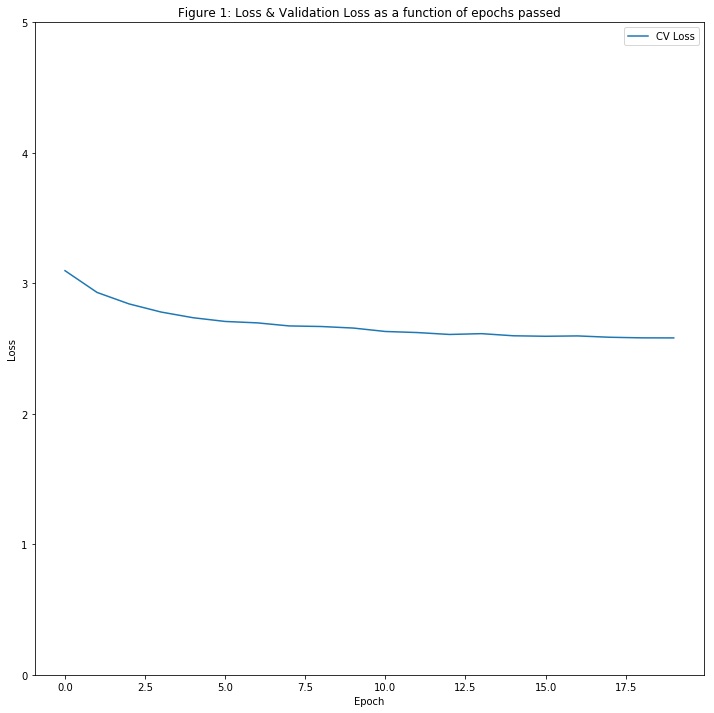

In [16]:
loss, val_loss = history.history['loss'] , history.history['val_loss'] 

#plt.plot(loss, label="Loss")
plt.plot(val_loss, label="CV Loss")
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(bottom=0, top=5.0)
plt.title('Figure 1: Loss & Validation Loss as a function of epochs passed')
plt.rcParams["figure.figsize"] = [12,12]
plt.show()

In [51]:
y_train_pred = model.predict_classes(X_train_scaled, verbose=0)
y_test_pred = model.predict_classes(X_test_scaled, verbose=0)
print(y_test_pred[0:50])
print(y_cold_test.values.flatten()[0:50])

train_acc = np.sum(y_cold_train_shuf.values.flatten() == y_train_pred, axis=0) / 44559
test_acc = np.sum(y_cold_test.values.flatten() == y_test_pred, axis=0) / 19097

print(f"Accuracy on training set: {train_acc}")
print(f"Accuracy on test set: {test_acc}")

[30 30 38 30 30 30 30 30 30 15 15 15 21 21 12 15 10 12 15 25 12 25 25 25
 12 25 15 15 15 15  5 15 27 15 15 12 10 15 12 10 12 10 32 12 21 25 15 15
 15 10]
[25 25 25 25 25 25 25 25 25 64 64 64 64 64 64 64 64 64 64 12 12 12 12 12
 12 12 43 15 15 15 15 15 15 15 15 12 12 12 12 12 12 12 43 12 21 12 10 15
 21 10]
Accuracy on training set: 0.3851073857133239
Accuracy on test set: 0.3129287322616118


In [54]:
train_acc_multiple=np.zeros(y_train_pred.shape, dtype = int)
test_acc_multiple=np.zeros(y_test_pred.shape, dtype = int)

for i in range(len(y_cold_train_multiple_shuf.values)):
    answer = y_cold_train_multiple_shuf.values[i]
    prediction = y_train_pred[i]
    
    if prediction in answer:
        train_acc_multiple[i] = 1

for i in range(len(y_cold_test_multiple.values)):
    answer = y_cold_test_multiple.values[i]
    prediction = y_test_pred[i]
    
    if prediction in answer:
        test_acc_multiple[i] = 1
        
print(train_acc_multiple)
print(test_acc_multiple)

print(np.sum(train_acc_multiple) / y_train_pred.shape[0])
print(np.sum(test_acc_multiple) / y_test_pred.shape[0])

[0 1 0 ... 0 0 0]
[0 0 1 ... 1 1 0]
0.45723647299086606
0.4010053935173064


In [56]:
#save json file of the model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")